<a href="https://colab.research.google.com/github/ahnnoah/study/blob/main/Colab/2022/9_%ED%8F%90%EB%A0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN으로 폐렴 X-ray 분류하기
안노아

In [ ]:
# 1번 셀

# package import
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import Model
from keras.layers import Conv2D, SeparableConv2D
from keras.layers import Input, Flatten
from keras.layers import BatchNormalization, MaxPool2D
from keras.layers import Dense, Dropout

from keras.preprocessing.image import load_img    # JPG 파일 처리 함수


In [ ]:
# 2번 셀

# 하이퍼 파라미터
MY_EPOCH = 200
MY_BATCH = 100
MY_RES = 180        # X-ray 사진의 해상도
MY_SHAPE = (MY_RES, MY_RES, 3)

# 모드 설정
DATA_MODE = 1
TRAIN_MODE = 1
MY_PATH = '/content/drive/MyDrive/dataset/chest'


In [ ]:
# 3번 셀

# 전역 변수 정의
T_tot = 0          # 학습용 이미지 갯수: 999
V_tot = 0          # 평가용 이미지 갯수: 200
N_tot = 0          # 정상 이미지 갯수: 500 혹은 100
P_tot = 0          # 폐렴 이미지 갯수: 500 혹은 100
N_path = []        # 정상 이미지 경로: 500 혹은 100
P_path = []        # 폐렴 이미지 경로: 500 혹은 100

X_train = np.zeros((0))   # 학습용 입력 데이터
Y_train = np.zeros((0))   # 학습용 출력 데이터
X_test = np.zeros((0))    # 평가용 입력 데이터
Y_test = np.zeros((0))    # 평가용 출력 데이터


In [ ]:
# 4번 셀

# 학습용 이미지 경로 처리
def train_path():
    global T_tot, N_tot, P_tot, N_path, P_path

    # 학습용 정상 이미지 경로 처리
    dir = os.path.join(MY_PATH, 'train/NORMAL')
    for file in os.listdir(dir):
        N_path.append(os.path.join(dir, file))
    N_tot = len(N_path)
    print('학습용 정상 이미지 개수:', N_tot)

    # 학습용 폐렴 이미지 경로 처리
    dir = os.path.join(MY_PATH, 'train/PNEUMONIA')
    for file in os.listdir(dir):
        P_path.append(os.path.join(dir, file))
    P_tot = len(P_path)
    print('학습용 폐렴 이미지 개수:', P_tot)

    T_tot = N_tot + P_tot
    print('전체 학습용 이미지 개수:', T_tot)


In [ ]:
# 5번 셀

# 학습용 이미지 해상도 통일
def train_resize():
    global T_tot, N_tot, P_tot, N_path, P_path
    global X_train, Y_train

    print('학습용 정상 이미지 처리')
    begin = time()

    # 학습용 데이터의 모양 선언
    X_train = np.zeros((T_tot, MY_RES, MY_RES, 3))
    Y_train = np.zeros((T_tot, 1))

    for i, path in enumerate(N_path):
        #tmp = load_img(path)
        #plt.imshow(tmp)
        #print(type(tmp))
        #print(np.array(tmp).shape)
        #plt.show()

        # 화소 낮추기
        img = load_img(path, 
                       target_size=(MY_RES, MY_RES))
        #print(np.array(img).shape)
        #plt.imshow(img)
        X_train[i] = img
        Y_train[i] = 0

    end = time()
    print('학습용 정상 이미지 처리 시간:', end - begin)

    print('학습용 폐렴 이미지 처리 시작')
    begin = time()

    for i, path in enumerate(P_path):
        img = load_img(path,
                       target_size=(MY_RES, MY_RES))
        X_train[i + N_tot] = img
        Y_train[i + N_tot] = 1

    end = time()
    print('학습용 폐렴 이미지 처리 시간:', end - begin)


In [ ]:
# 6번 셀 (= 4번 셀과 유사)

# 평가용 데이터 경로 처리
def test_path():
    global V_tot, N_tot, P_tot, N_path, P_path

    # 평가용 정상 이미지 경로 처리
    N_path = []
    dir = os.path.join(MY_PATH, 'test/NORMAL')
    for file in os.listdir(dir):
        N_path.append(os.path.join(dir, file))
    N_tot = len(N_path)
    print('평가용 정상 이미지 개수:', N_tot)

    # 평가용 폐렴 이미지 경로 처리
    P_path = []
    dir = os.path.join(MY_PATH, 'test/PNEUMONIA')
    for file in os.listdir(dir):
        P_path.append(os.path.join(dir, file))
    P_tot = len(P_path)
    print('평가용 폐렴 이미지 개수:', P_tot)

    V_tot = N_tot + P_tot
    print('전체 평가용 이미지 개수:', V_tot)


In [ ]:
# 7번 셀 (5번 셀과 유사)

# 평가용 이미지 화소 통일
def test_resize():
    global V_tot, N_tot, P_tot, N_path, P_path
    global X_test, Y_test

    print('평가용 정상 이미지 처리')
    begin = time()

    # 평가용 데이터의 모양 선언
    X_test = np.zeros((V_tot, MY_RES, MY_RES, 3))
    Y_test = np.zeros((V_tot, 1))

    for i, path in enumerate(N_path):
        # 화소 낮추기
        img = load_img(path, 
                       target_size=(MY_RES, MY_RES))
        X_test[i] = img
        Y_test[i] = 0

    end = time()
    print('평가용 정상 이미지 처리 시간:', end - begin)

    print('평가용 폐렴 이미지 처리 시작')
    begin = time()

    for i, path in enumerate(P_path):
        img = load_img(path,
                       target_size=(MY_RES, MY_RES))
        X_test[i + N_tot] = img
        Y_test[i + N_tot] = 1

    end = time()
    print('평가용 폐렴 이미지 처리 시간:', end - begin)


In [ ]:
# 8번 셀

# 데이터 파일 저장
def save_data():
    path = os.path.join(MY_PATH, 'chest.npy')
    with open(path, 'wb') as file:
        np.save(file, X_train)
        np.save(file, Y_train)
        np.save(file, X_test)
        np.save(file, Y_test)

    print('4분할 데이터 파일 저장 완료')


In [ ]:
# 9번 셀

# 저장된 numpy 파일 읽기
def read_data():
    global X_train, Y_train, X_test, Y_test

    path = os.path.join(MY_PATH, 'chest.npy')
    with open(path, 'rb') as file:
        X_train = np.load(file)
        Y_train = np.load(file)
        X_test = np.load(file)
        Y_test = np.load(file)

    print('4분할 데이터 파일 읽기 종료')


In [ ]:
# 10번 셀

# 데이터 처리 콘트롤 타워
if DATA_MODE:
    train_path()
    train_resize()
    test_path()
    test_resize()
    save_data()
else:
    read_data()



4분할 데이터 파일 읽기 종료


[0.]
학습용 입력 데이터: (999, 180, 180, 3)
학습용 출력 데이터: (999, 1)
평가용 입력 데이터: (200, 180, 180, 3)
평가용 출력 데이터: (200, 1)


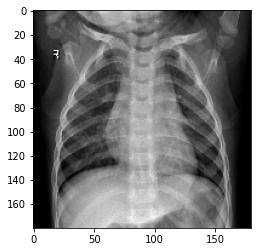

In [ ]:
# 11번 셀

# 이미지 데이터 [0, 1] 스케일링
X_train = X_train / 255
X_test = X_test / 255

# 샘플 데이터 확인
print(Y_train[0])
plt.imshow(X_train[0])

# 데이터 모양 확인
print('학습용 입력 데이터:', X_train.shape)
print('학습용 출력 데이터:', Y_train.shape)

print('평가용 입력 데이터:', X_test.shape)
print('평가용 출력 데이터:', Y_test.shape)


In [ ]:
# 12번 셀

# 반복 합성곱 구조 구현
def conv_block(filters, input):
    x = SeparableConv2D(filters=filters,
                        kernel_size=3,
                        padding='same',
                        activation='relu')(input)

    x = SeparableConv2D(filters=filters,
                        kernel_size=3,
                        padding='same',
                        activation='relu')(x)

    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=2)(x)

    return x

In [ ]:
# 13번 셀

# 반복 완전 연결 구조 구현
def dense_block(units, drop, input):
    x = Dense(units=units,
              activation='relu')(input)

    x = BatchNormalization()(x)
    x = Dropout(drop)(x)

    return x


In [ ]:
# 14번 셀

# 전체 CNN 구현
# 입력층
my_input = Input(shape=(MY_SHAPE))

# 블럭 2
x = Conv2D(filters=16,
           kernel_size=3,
           padding='same',
           activation='relu')(my_input)

x = Conv2D(filters=16,
           kernel_size=3,
           padding='same',
           activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)

# 블럭 3
x = conv_block(32, x)

# 블럭 4
x = conv_block(64, x)

# 블럭 5
x = conv_block(128, x)
x = Dropout(0.2)(x)

# 블럭 6
x = conv_block(256, x)
x = Dropout(0.2)(x)

# 블럭 7
x = Flatten()(x)

# 블럭 8
x = dense_block(512, 0.7, x)
x = dense_block(128, 0.5, x)
x = dense_block(64, 0.3, x)

# 블럭 9
x = Dense(units=1,
          activation='sigmoid')(x)

# CNN 요약
model = Model(inputs=my_input,
              outputs=x)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 90, 90, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 90, 90, 32)       1344  

In [ ]:
# 15번 셀

# CNN 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

path = os.path.join(MY_PATH, 'chest.h5')
if TRAIN_MODE:
    print('학습 시작')
    begin = time()

    model.fit(X_train,
            Y_train,
            epochs=MY_EPOCH,
            batch_size=MY_BATCH,
            verbose=1)

    end = time()
    print('총 학습 시간:', end - begin)
    model.save_weights(path)
else:
    model.load_weights(path)


In [ ]:
# 16번 셀

# CNN 평가
score = model.evaluate(X_test,
                       Y_test)

print('최종 정확도:', score[1])


7/7 [==============================] - 2s 24ms/step - loss: 0.7097 - acc: 0.8600
최종 정확도: 0.8600000143051147


평가용 0번 문제 예측: [5.135981e-06]
평가용 0번 문제 정답: [0.]


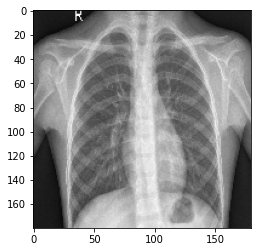

In [ ]:
# 17번 셀

# CNN 예측
pred = model.predict(X_test)
print('평가용 0번 문제 예측:', pred[0])
print('평가용 0번 문제 정답:', Y_test[0])
plt.imshow(X_test[0])


In [ ]:
# 18번 셀
# separable 결과
# Total params: 3,496,801
# 학습 시간: 580초
# 최종 정확도: 0.8600000143051147

# conv2D 결과
# limsk@gatech.edu
